In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
import re
import string

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer

nltk.download("stopwords")

import tweepy

import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv(r"C:\Users\LENOVO\Downloads\Tweets.csv")
df= df.dropna()

df=df.rename(columns={'text': 'tweets','sentiment': 'label'})

tweets=df['tweets']

def preprocess_text(text):
    text =text.lower() # Converting to lower case
    text = re.sub(r"http\S+", "", text)  # Excluding hyperlinks
    text = re.sub(r"www\.\S+", " ", text)  # Excluding links starting with 'www'
    text = re.sub(r"@\w+", " ", text)  # Excluding tagged data
    text = re.sub(r"[^A-Za-z\s]", " ", text)  # Excluding non-alphabetical characters except whitespace
    return text.strip()

cleaned_tweets=[preprocess_text(tweet) for tweet in tweets]

stop_words=set(stopwords.words('english'))
tokenizer=TweetTokenizer()

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in stop_words]
    return tokens

preprocessed_tweets=[preprocess(tweet) for tweet in cleaned_tweets]
preprocessed_tweets_str=[" ".join(tokens) for tokens in preprocessed_tweets]

df['preprocessed_tweets'] = preprocessed_tweets
def polarity(text):
    return TextBlob(text).sentiment.polarity

polarities = [polarity(' '.join(tokens)) for tokens in preprocessed_tweets]
df['polarity'] = polarities
df[['preprocessed_tweets', 'polarity']]

map_dict={
    'neutral':0,
    'positive':1,
    'negative':2,
}
df['label']=df['label'].map(map_dict)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Let's get into implementing a RNN Model, specifically a LSTM and GRU models, for getting predictions**

### Recurrent Neural Networks (RNNs):

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to process sequences of data, making them particularly well-suited for tasks involving sequences, time-series data, and natural language processing. Unlike traditional feedforward neural networks, RNNs have the ability to maintain a memory of previous inputs, allowing them to capture temporal dependencies in data.

![rnn](https://miro.medium.com/max/4136/1*SKGAqkVVzT6co-sZ29ze-g.png)

### LSTM (Long Short-Term Memory):

LSTM is a type of recurrent neural network architecture that addresses the vanishing gradient problem in traditional RNNs, which hinders their ability to capture long-range dependencies in sequences. 

LSTM networks were introduced to overcome this limitation and are known for their ability to effectively capture and remember information over extended time intervals. 

LSTM networks contain memory cells with gating mechanisms that control the flow of information, making them particularly well-suited for sequence-based tasks.

#### Architecture:

![lstm](https://miro.medium.com/v2/resize:fit:984/1*Mb_L_slY9rjMr8-IADHvwg.png)

1. Cell State: The core memory of the LSTM, which can maintain information across time steps.

2. Input Gate: Controls the input information flow into the cell state.

3. Forget Gate: Controls the removal of information from the cell state.

4. Output Gate: Determines the output information based on the cell state.

In [3]:
#Importing libraries:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical

In [4]:
X=preprocessed_tweets_str
y=df['label'].values

In [5]:
#Spliting the dataset for training and testing:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:
#transforming target variable into one-hot encoded format:
y_train_categorical=to_categorical(y_train)
y_test_categorical=to_categorical(y_test)

In [7]:
#Preparing 'X' data for modelling:
tokenizer=Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train)

X_train_seq=tokenizer.texts_to_sequences(X_train)
X_test_seq=tokenizer.texts_to_sequences(X_test)

X_train_padded=pad_sequences(X_train_seq, maxlen=100)
X_test_padded=pad_sequences(X_test_seq, maxlen=100)

The above code initializes a tokenizer with a vocabulary size of 500, fits it on the training data, converts the text data in both training and testing sets into sequences of token indices, and then pads these sequences to a maximum length of 100 to prepare them for input into a neural network model.

In [8]:
#Creating Sequential neural network model using Keras:
model=Sequential()
model.add(Embedding(input_dim=5000,output_dim=100,input_length=100))
model.add(LSTM(128,dropout=0.2,return_sequences=True))
model.add(LSTM(64,dropout=0.2,return_sequences=True))
model.add(LSTM(32, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

We have started with an embedding layer that takes token indices as input and converts them into dense vectors of dimension 100. 

The model then adds three LSTM layers with different configurations: the first LSTM layer has 128 units, uses a dropout rate of 0.2, and returns sequences; the second LSTM layer also has 64 units, uses a dropout rate of 0.2, and returns sequences; the third LSTM layer has 32 units and uses a dropout rate of 0.2. 

A dropout layer is added after the LSTM layers to prevent overfitting. 

Finally, a dense output layer with 3 units and a softmax activation function is added to classify the sentiment of the input texts. The model is compiled with a categorical cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric.

In [9]:
#Training our Model:
hist=model.fit(X_train_padded,y_train_categorical,epochs=5,batch_size=64,
         validation_data=(X_test_padded,y_test_categorical))
hist

Epoch 1/5
344/344 [==============================] - 106s 285ms/step - loss: 0.9213 - accuracy: 0.5606 - val_loss: 0.7920 - val_accuracy: 0.6663
Epoch 2/5
344/344 [==============================] - 98s 286ms/step - loss: 0.7804 - accuracy: 0.6744 - val_loss: 0.7738 - val_accuracy: 0.6738
Epoch 3/5
344/344 [==============================] - 104s 303ms/step - loss: 0.7656 - accuracy: 0.6825 - val_loss: 0.7719 - val_accuracy: 0.6736
Epoch 4/5
344/344 [==============================] - 98s 285ms/step - loss: 0.7578 - accuracy: 0.6848 - val_loss: 0.7712 - val_accuracy: 0.6756
Epoch 5/5
344/344 [==============================] - 103s 300ms/step - loss: 0.7480 - accuracy: 0.6889 - val_loss: 0.7664 - val_accuracy: 0.6729


The above epochs shows the effectiveness of the model's learning process, showing how the loss function minimized while accuracy improved, a testament to the model's ability to comprehend the complexities within the sentiment analysis task. By the end of the five epochs, the model achieved a training accuracy of 68.89% and a validation accuracy of 67.29%, signifying its ability to generalize effectively to new, unseen data.

In [10]:
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(f"Test Loss of LSTM: {loss:.4f}")
print(f"Test Accuracy of LSTM: {accuracy:.4f}")

172/172 [==============================] - 13s 75ms/step - loss: 0.7664 - accuracy: 0.6729
Test Loss of LSTM: 0.7664
Test Accuracy of LSTM: 0.6729


In [11]:
train_loss=hist.history['loss']
train_acc=hist.history['accuracy']
test_loss=hist.history['val_loss']
test_acc=hist.history['val_accuracy']

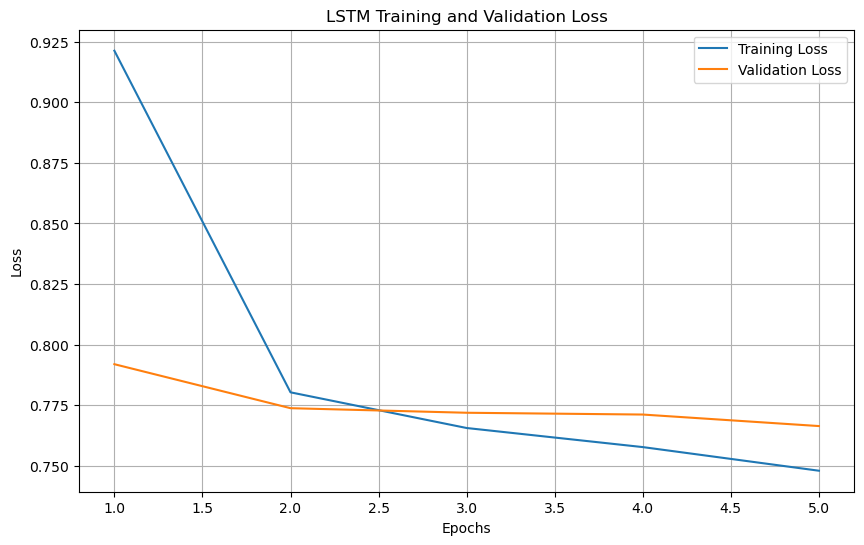

In [12]:
#Loss :
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(train_loss) + 1),train_loss, label='Training Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

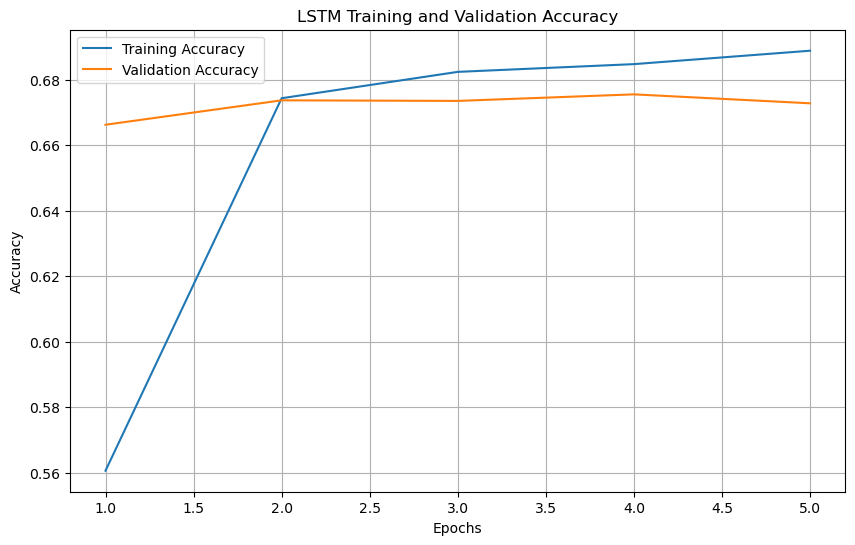

In [13]:
#Accuracy:
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(train_acc) + 1),train_acc, label='Training Accuracy')
plt.plot(range(1,len(test_acc) + 1),test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### GRU (Gated Recurrent Unit) Models:
GRU, short for Gated Recurrent Unit, is a type of recurrent neural network (RNN) architecture that was introduced as a variation of the traditional LSTM (Long Short-Term Memory) model. GRUs are designed to address some of the limitations of standard RNNs and LSTMs by offering a more streamlined architecture with similar capabilities.

GRUs are particularly effective in handling long-range dependencies and capturing sequential patterns in data, which makes them well-suited for tasks such as natural language processing, time series analysis, and speech recognition.

![gru](https://miro.medium.com/max/1400/1*jhi5uOm9PvZfmxvfaCektw.png)

#### Update Gate
The update gate determines how much of the previous hidden state should be combined with the candidate new state to produce the current hidden state. It controls the flow of information from the past to the present by deciding how much of the old memory to keep and how much new information to incorporate.

#### Reset Gate (r):
The reset gate determines how much of the previous hidden state should be "reset" before considering the candidate new state. It allows the network to ignore irrelevant or outdated information from the past hidden state and selectively focus on relevant information.

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout

In [16]:
vocab_size=10000  
embedding_dim=100
max_sequence_length=100 

output_size=3 

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_size, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru (GRU)                   (None, 100, 64)           31872     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1045891 (3.99 MB)
Trainable params: 1045

In [17]:
# Train the model
batch_size=32  
num_epochs=10  


hist=model.fit(X_train_padded,y_train_categorical, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)
hist

Epoch 1/10
619/619 [==============================] - 119s 183ms/step - loss: 0.8653 - accuracy: 0.6093 - val_loss: 0.7961 - val_accuracy: 0.6712
Epoch 2/10
619/619 [==============================] - 105s 169ms/step - loss: 0.7813 - accuracy: 0.6745 - val_loss: 0.7835 - val_accuracy: 0.6726
Epoch 3/10
619/619 [==============================] - 96s 155ms/step - loss: 0.7666 - accuracy: 0.6830 - val_loss: 0.7751 - val_accuracy: 0.6730
Epoch 4/10
619/619 [==============================] - 97s 157ms/step - loss: 0.7590 - accuracy: 0.6833 - val_loss: 0.7812 - val_accuracy: 0.6717
Epoch 5/10
619/619 [==============================] - 96s 155ms/step - loss: 0.7481 - accuracy: 0.6883 - val_loss: 0.7794 - val_accuracy: 0.6680
Epoch 6/10
619/619 [==============================] - 88s 143ms/step - loss: 0.7372 - accuracy: 0.6927 - val_loss: 0.7845 - val_accuracy: 0.6662
Epoch 7/10
619/619 [==============================] - 96s 156ms/step - loss: 0.7314 - accuracy: 0.6930 - val_loss: 0.7923 - val_

In [18]:
loss, accuracy=model.evaluate(X_test_padded, y_test_categorical)

print(f"Test Loss of GRU: {loss:.4f}")
print(f"Test Accuracy of GRU: {accuracy:.4f}")

172/172 [==============================] - 4s 20ms/step - loss: 0.7957 - accuracy: 0.6614
Test Loss of GRU: 0.7957
Test Accuracy of GRU: 0.6614


In [19]:
train_loss=hist.history['loss']
train_acc=hist.history['accuracy']
test_loss=hist.history['val_loss']
test_acc=hist.history['val_accuracy']

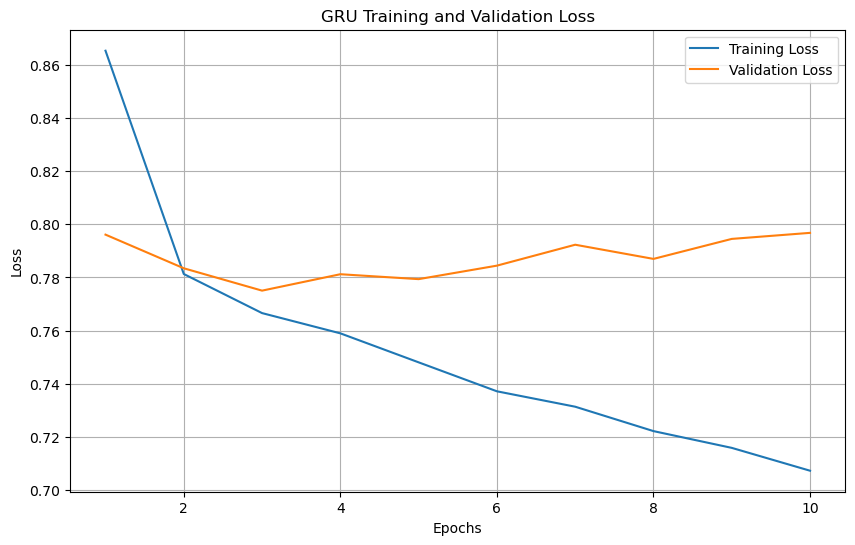

In [20]:
#Loss :
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(train_loss) + 1),train_loss, label='Training Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

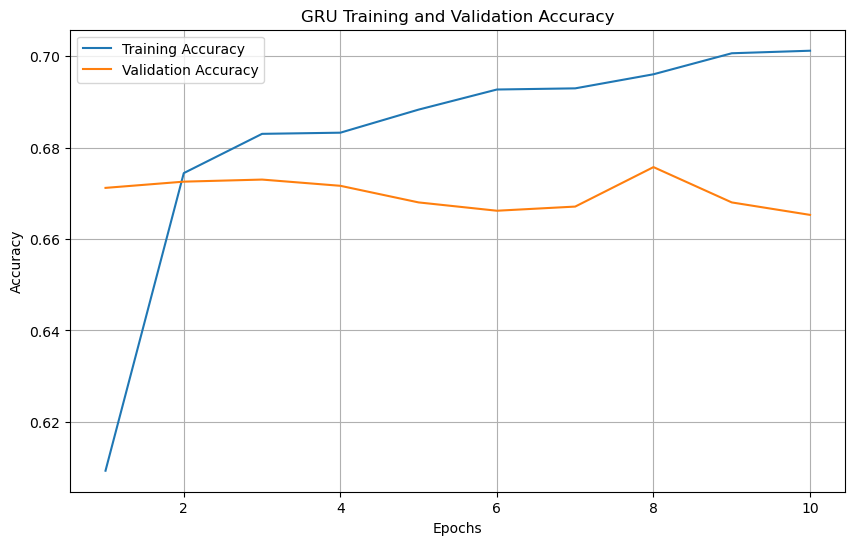

In [21]:
#Accuracy:
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(train_acc) + 1),train_acc, label='Training Accuracy')
plt.plot(range(1,len(test_acc) + 1),test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GRU Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The GRU model underwent training over 10 epochs, with varying changes in loss and accuracy metrics. While the model exhibited improvements in training accuracy, the validation accuracy showed some fluctuations. The test evaluation indicated a test accuracy of 66.14%, demonstrating the model's performance on unseen data. 

After all observations, I have decided to leverage the TF-IDF (Term Frequency-Inverse Document Frequency) methods in our approach, as they consistently yield promising accuracy scores. This technique holds the potential to enhance our model's performance and provide accurate sentiment analysis results.